# Example 4: Classification

## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

create the two moon dataset

cuda:0


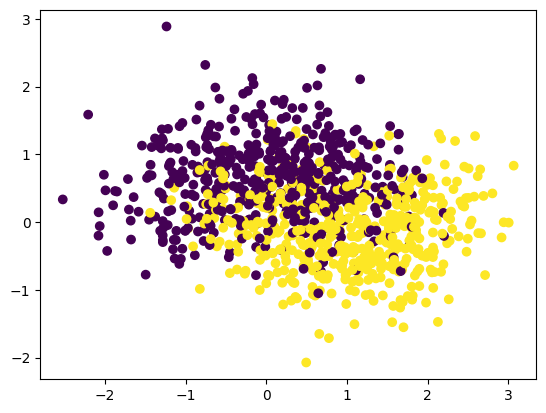

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import mlflow
import mlflow.pytorch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

dataset_noise = 0.5

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=dataset_noise, random_state=1)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=dataset_noise, random_state=2)


dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

cuda:0


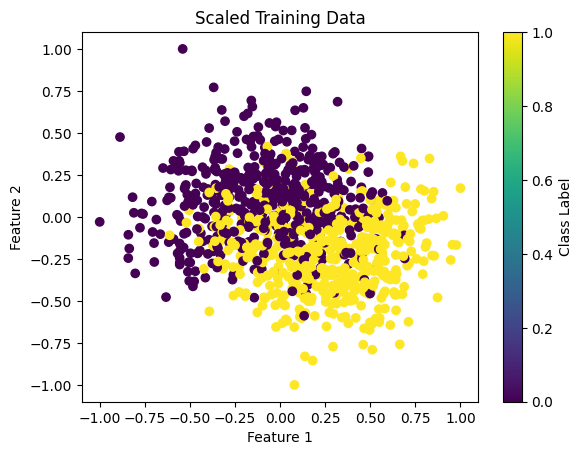

In [2]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mlflow
import mlflow.pytorch
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

dataset_noise = 0.5

# Generate the dataset
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=dataset_noise, random_state=1)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=dataset_noise, random_state=2)

# Scale the input data between -1 and 1
def scale_to_minus_one_one(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    scaled_data = 2 * (data - min_val) / (max_val - min_val) - 1
    return scaled_data

train_input_scaled = scale_to_minus_one_one(train_input)
test_input_scaled = scale_to_minus_one_one(test_input)

# Convert to PyTorch tensors
dtype = torch.get_default_dtype()
dataset = {}
dataset['train_input'] = torch.from_numpy(train_input_scaled).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input_scaled).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:, None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:, None]).type(dtype).to(device)

# Visualize the training data
X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), c=y[:, 0].cpu().detach().numpy())
plt.title("Scaled Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class Label')
plt.show()

In [3]:
# # Generate the original dataset
# train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
# test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

# # Convert to PyTorch tensors
# dtype = torch.get_default_dtype()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# dataset = {}
# dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
# dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
# dataset['train_label'] = torch.from_numpy(train_label[:, None]).type(dtype).to(device)
# dataset['test_label'] = torch.from_numpy(test_label[:, None]).type(dtype).to(device)

# # Function to add noise
# def add_noise(data, noise_level=0.1):
#     noise = np.random.normal(0, noise_level, data.shape)  # Generate Gaussian noise
#     return data + noise

# # Add noise to the training and test inputs
# noise_level = 0.1  # Adjust the noise level as needed
# dataset['train_input'] = add_noise(dataset['train_input'].cpu().numpy(), noise_level)
# dataset['test_input'] = add_noise(dataset['test_input'].cpu().numpy(), noise_level)

# # Convert back to PyTorch tensors
# dataset['train_input'] = torch.from_numpy(dataset['train_input']).type(dtype).to(device)
# dataset['test_input'] = torch.from_numpy(dataset['test_input']).type(dtype).to(device)

# # Visualize the noisy training data
# X = dataset['train_input']
# y = dataset['train_label']
# plt.scatter(X[:, 0].cpu().detach().numpy(), X[:, 1].cpu().detach().numpy(), c=y[:, 0].cpu().detach().numpy())
# plt.title('Noisy Moons Dataset')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')


In [4]:
#base_width=[3,3,3]
d=5
w=2
base_width=[w]*d
#base_width=[1]
steps=100
grid=5
k=3
sp_trainable=False
sb_trainable=False
affine_trainable=False
update_grid=False
mode=None
#mode="sigmoid"
#width = [2,*base_width,1]
#print(width)

Train KAN

checkpoint directory created: ./model
saving model version 0.0


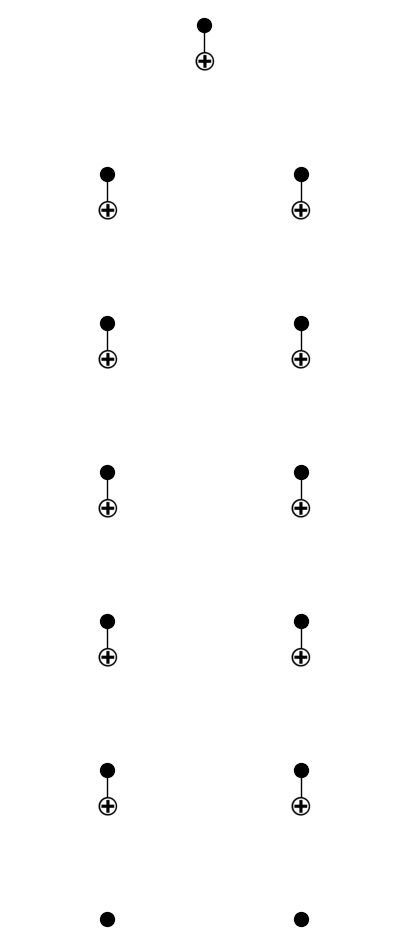

In [5]:
#width=[2,1]
seed=0
noise_scale=1
#noise_scale=0.3
#noise_scale=100
width = [2,*base_width,1]
model = KAN(width=width, grid=grid, k=k, device=device, 
            sp_trainable=sp_trainable, sb_trainable=sb_trainable, affine_trainable=affine_trainable, 
            seed=0, 
            #noise_scale=noise_scale,
            base_fun="silu",
            #grid_eps=1,
            mode=mode
            )
model(dataset['train_input'])
model.plot()

Reinit KAN

In [6]:
# model = KAN(width=width, grid=grid, k=k, device=device, 
#             sp_trainable=sp_trainable, sb_trainable=sb_trainable, affine_trainable=affine_trainable, 
#             seed=0, noise_scale=noise_scale,
#             base_fun="silu",
#             #grid_eps=1,
#             mode=mode
#             )

# y, preacts, postacts, postspline =model(dataset['train_input'])

def print_ranges(model):
    for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.acts)):
        print("layer_index", layer_index)
        print(act_fun.coef.shape, acts.shape)
        for idx in range(acts.shape[1]):
            print(f"idx {idx}:", "mean:", acts[idx].mean().item(), "std:", acts[idx].std().item())
            print(f"idx {idx}:", acts[idx].min().item(), acts[idx].max().item())

def reinit(model:KAN):
    #grid_range = model.grid_range
    depth = len(model.act_fun)


    for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):
        #print(act_fun.coef.shape, acts.shape)
        #print(acts[0].min().item(), acts[0].max().item())
        grid_num = act_fun.num
        coef = act_fun.coef
        #layer_scale = ((layer_index+1)/depth)*(grid_num*5)
        #layer_scale = ((layer_index+1)/depth)*10 #(grid_num**2)
        #print(coef.shape)
        #coef = coef * layer_scale

        #with torch.no_grad():
        layer_scale = ((layer_index+1)/depth)*2 #10
        stds = torch.std(acts, dim=0).view(-1, 1, 1) 
        #print(stds)
        #print(stds.shape)
        #coef = coef / stds

        with torch.no_grad():
            #coef = coef * stds/coef.std()
            coef = coef/coef.std()
            coef = coef * layer_scale

        #coef[0,:,:] = coef[0,:,:] / coef[0,:,:].std()
        #coef[1,:,:] = coef[1,:,:] / coef[0,:,:].std()

        #act_fun.coef = torch.nn.Parameter(coef).requires_grad_(True)
        act_fun.coef = torch.nn.Parameter(coef)




In [7]:
# print("Standart")
# model(dataset['train_input'])
# print_ranges(model)
# reinit(model)
# print("Rescaling")
# model(dataset['train_input'])
# print_ranges(model)

# model.plot()

In [8]:
model.device

device(type='cuda', index=0)

In [9]:
def reinit_linear(model:KAN):
    #grid_range = model.grid_range
    depth = len(model.act_fun)


    for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):

        grid_num = act_fun.num
        coef = act_fun.coef

        with torch.no_grad():
            mean = 0
            std = 0.1

            coef.fill_(1)
            noise = torch.normal(mean=mean, std=std, size=coef.shape).to(model.device)
            #coef = coef * noise
            #coef = coef * 2
            coef = torch.cumsum(coef, dim=2)#/coef.shape[2]
            coef = coef - 1
            coef = coef / (coef.shape[2]-1)
            coef = coef - coef.mean()
            #coef = coef - 0.5
            coef = coef * 2
            coef = coef + noise
            print(coef)

            #layer_scale = ((layer_index+1)/depth)*2
            #stds = torch.std(acts, dim=0).view(-1, 1, 1) 
            #coef = coef/coef.std()
            #coef = coef * layer_scale



        act_fun.coef = torch.nn.Parameter(coef)



In [10]:
# model(dataset['train_input'])
# reinit_linear(model)
# print("Rescaling")
# model(dataset['train_input'])
# print_ranges(model)
# model.plot()

In [11]:

for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):

    grid_num = act_fun.num
    coef = act_fun.coef
    grid = act_fun.grid
    print("grid_num", grid_num)
    print("coef", coef.shape)
    print("grid", grid.shape)
    
    break

grid_num 5
coef torch.Size([2, 2, 8])
grid torch.Size([2, 12])


In [12]:
def reinit_width(model:KAN):
    #grid_range = model.grid_range
    depth = len(model.act_fun)


    for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):

        grid_num = act_fun.num
        coef = act_fun.coef
        print

        with torch.no_grad():
            
            print(coef.shape)
            
            mean = 0
            std = 0.1

            coef.fill_(1)
            noise = torch.normal(mean=mean, std=std, size=coef.shape).to(model.device)
            #coef = coef * noise
            #coef = coef * 2
            coef = torch.cumsum(coef, dim=2)#/coef.shape[2]
            coef = coef - 1
            coef = coef / (coef.shape[2]-1)
            coef = coef - coef.mean()
            #coef = coef - 0.5
            coef = coef * 2
            coef = coef + noise

            #coef.fill_(0)
            #noises = (torch.rand(self.num+1, self.in_dim, self.out_dim) - 1/2) * noise_scale / num


            #print(coef.shape)

            #layer_scale = ((layer_index+1)/depth)*2
            #stds = torch.std(acts, dim=0).view(-1, 1, 1) 
            #coef = coef/coef.std()
            #coef = coef * layer_scale



        act_fun.coef = torch.nn.Parameter(coef)



torch.Size([2, 2, 8])
torch.Size([2, 2, 8])
torch.Size([2, 2, 8])
torch.Size([2, 2, 8])
torch.Size([2, 2, 8])
torch.Size([2, 1, 8])


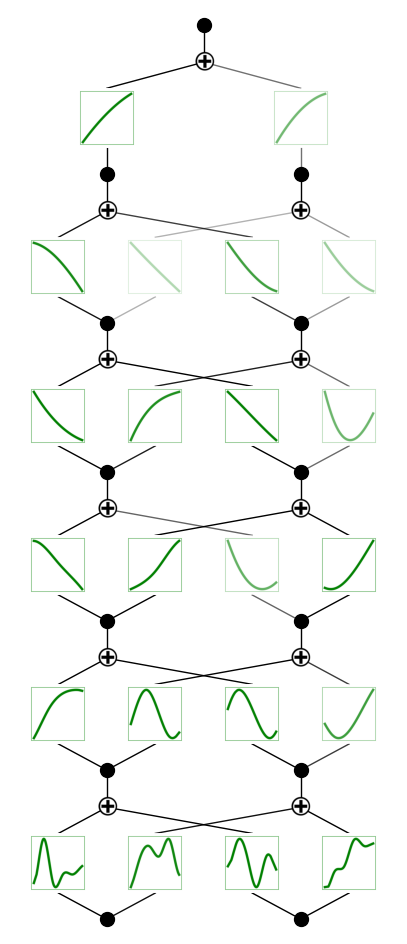

In [13]:
def reinit2(model:KAN):
    #grid_range = model.grid_range
    depth = len(model.act_fun)


    for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):

        grid_num = act_fun.num
        coef = act_fun.coef

        with torch.no_grad():
            print(coef.shape)
            rand = torch.rand(coef.shape).to(model.device)
            coef = (rand - 1/2)*2 * 1.0/w
            coef.to(model.device)

        act_fun.coef = torch.nn.Parameter(coef)
        #act_fun.coef.to(device)

#reinit(model)
reinit2(model)
model(dataset['train_input'])
model.plot()

In [14]:
means = []
vars = []
mins = []
maxs = []
for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):
    grid_num = act_fun.num
    coef = act_fun.coef

    mean_value = acts.mean()
    var_value = acts.var()
    min_value = acts.min()
    max_value = acts.max()

    means.append(mean_value.cpu().numpy())
    vars.append(var_value.cpu().numpy())
    mins.append(min_value.cpu().numpy())
    maxs.append(max_value.cpu().numpy())

    print(layer_index, grid_num, coef.shape, acts.shape)
    print(f"mean={mean_value:.2e}, var={var_value:.2e}, min={min_value:.2e}, max={max_value:.2e}")

0 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=1.14e-02, var=1.09e-01, min=-1.00e+00, max=1.00e+00
1 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=-6.64e-02, var=3.27e-02, min=-4.69e-01, max=3.69e-01
2 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=7.62e-02, var=5.25e-02, min=-2.45e-01, max=5.22e-01
3 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=-6.18e-02, var=1.03e-02, min=-2.57e-01, max=1.03e-01
4 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=-4.56e-02, var=1.50e-02, min=-2.31e-01, max=1.71e-01
5 5 torch.Size([2, 1, 8]) torch.Size([1000, 1, 2])
mean=-7.06e-02, var=4.17e-02, min=-3.33e-01, max=1.51e-01


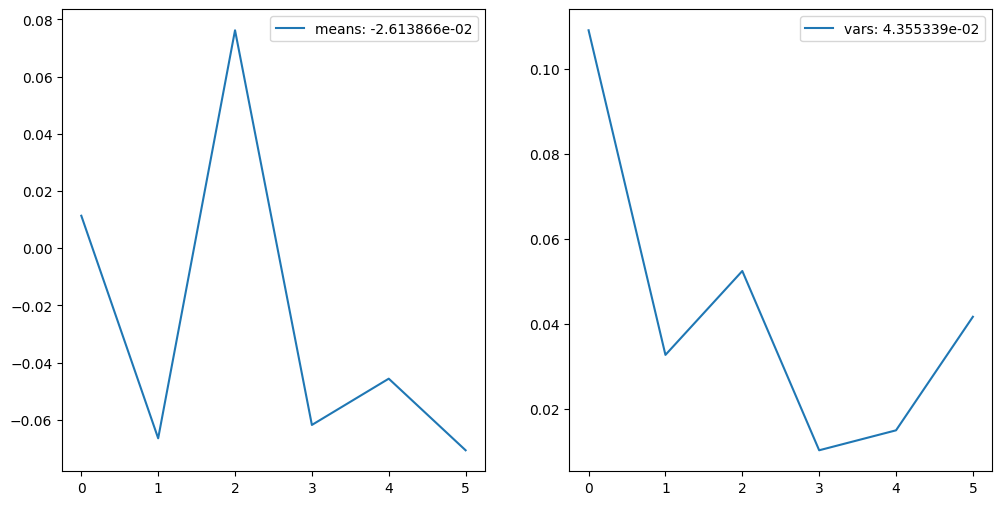

In [15]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(means, label=f"means: {np.mean(means):2e}")
axs[0].legend()
axs[1].plot(vars, label=f"vars: {np.mean(vars):2e}")
axs[1].legend()
plt.show()

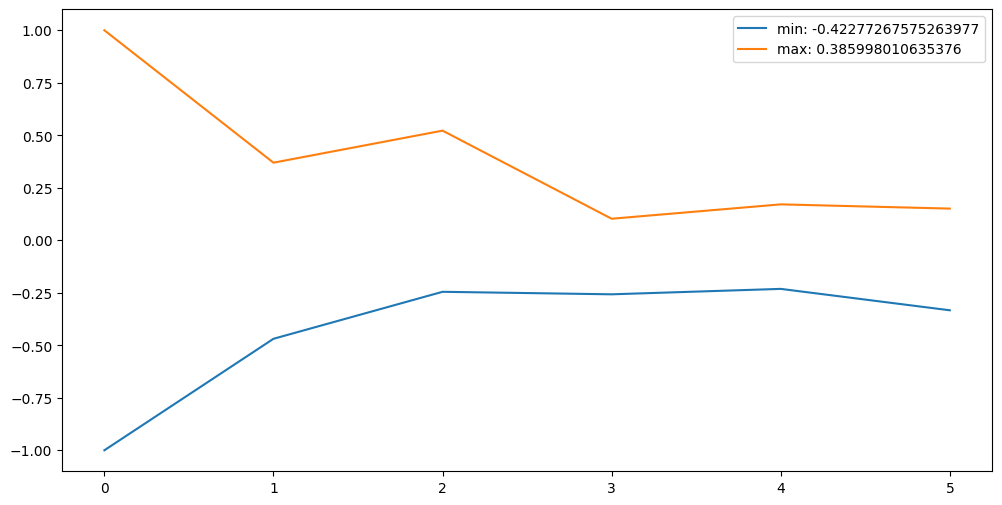

In [16]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
axs.plot(mins, label=f"min: {np.mean(mins)}")
axs.plot(maxs, label=f"max: {np.mean(maxs)}")
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

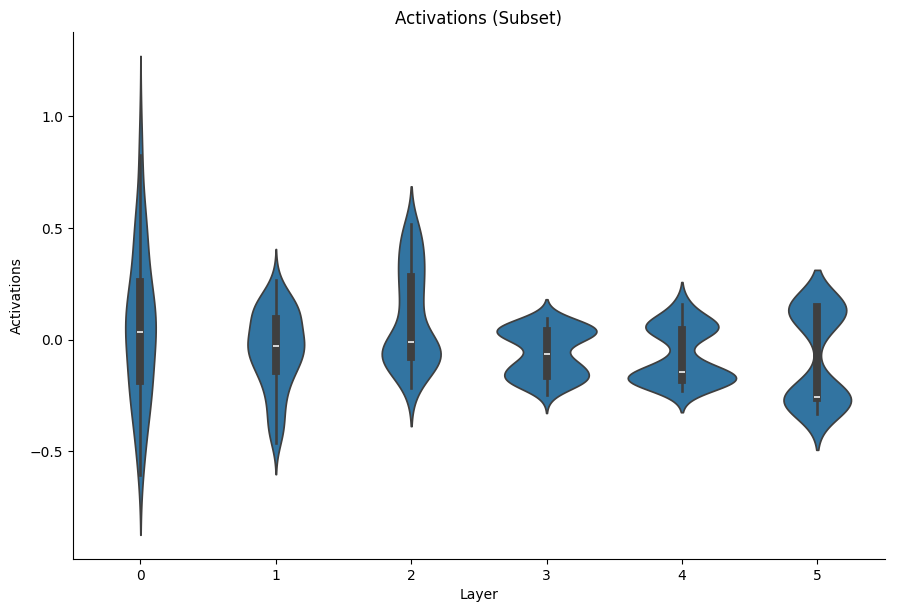

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Assuming model.act_fun and model.spline_preacts are defined
data = []
sample_size = 100  # Define the number of samples you want from each layer

for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun, model.spline_preacts)):
    acts_np = torch.flatten(acts).cpu().numpy()
    
    # Sample a subset of activations if there are more than sample_size
    if len(acts_np) > sample_size:
        sampled_acts = np.random.choice(acts_np, sample_size, replace=False)
    else:
        sampled_acts = acts_np  # Use all if less than sample_size
    
    # Append layer index and sampled activations to the data list
    data.extend([(layer_index, act) for act in sampled_acts])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Layer', 'Activation'])

plt.figure(figsize=(12, 6))

# Create a violin plot
sns.catplot(data=df, x="Layer", y="Activation", kind="violin", height=6, aspect=1.5)

# Adding labels and title
plt.title('Activations (Subset)')
plt.xlabel('Layer')
plt.ylabel('Activations')

# Show plot
plt.show()

/home/student/l/luniehaus/cv_home/dev-uos/miniconda/envs/pykan/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


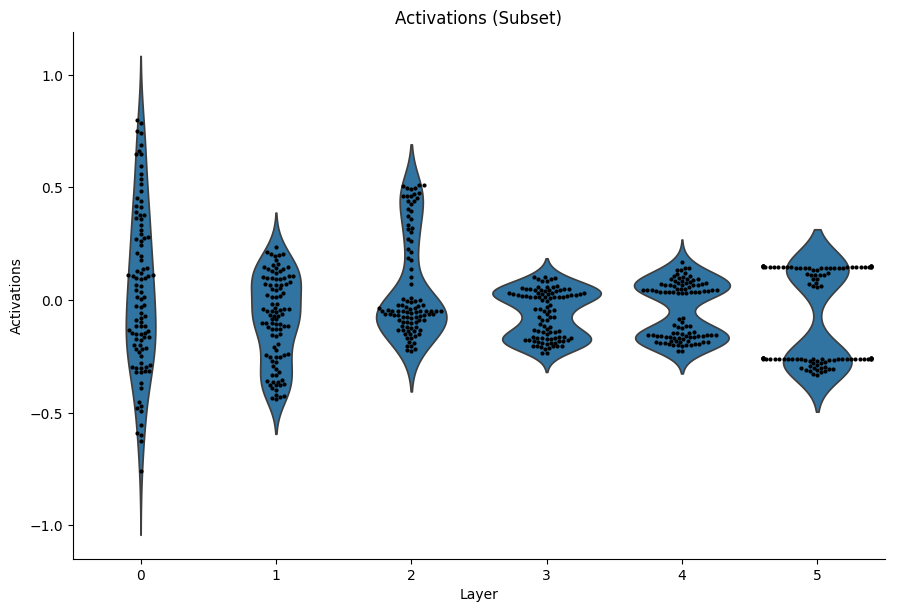

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Assuming model.act_fun and model.spline_preacts are defined
data = []
sample_size = 100  # Define the number of samples you want from each layer

for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun, model.spline_preacts)):
    acts_np = torch.flatten(acts).cpu().numpy()
    
    # Sample a subset of activations if there are more than sample_size
    if len(acts_np) > sample_size:
        sampled_acts = np.random.choice(acts_np, sample_size, replace=False)
    else:
        sampled_acts = acts_np  # Use all if less than sample_size
    
    # Append layer index and sampled activations to the data list
    data.extend([(layer_index, act) for act in sampled_acts])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Layer', 'Activation'])

# Create a violin plot
g = sns.catplot(data=df, x="Layer", y="Activation", kind="violin", inner=None, height=6, aspect=1.5)

# Overlay a swarm plot
sns.swarmplot(data=df, x="Layer", y="Activation", color="k", size=3, ax=g.ax)

# Adding labels and title
plt.title('Activations (Subset)')
plt.xlabel('Layer')
plt.ylabel('Activations')

# Show plot
plt.show()

/home/student/l/luniehaus/cv_home/dev-uos/miniconda/envs/pykan/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/student/l/luniehaus/cv_home/dev-uos/miniconda/envs/pykan/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


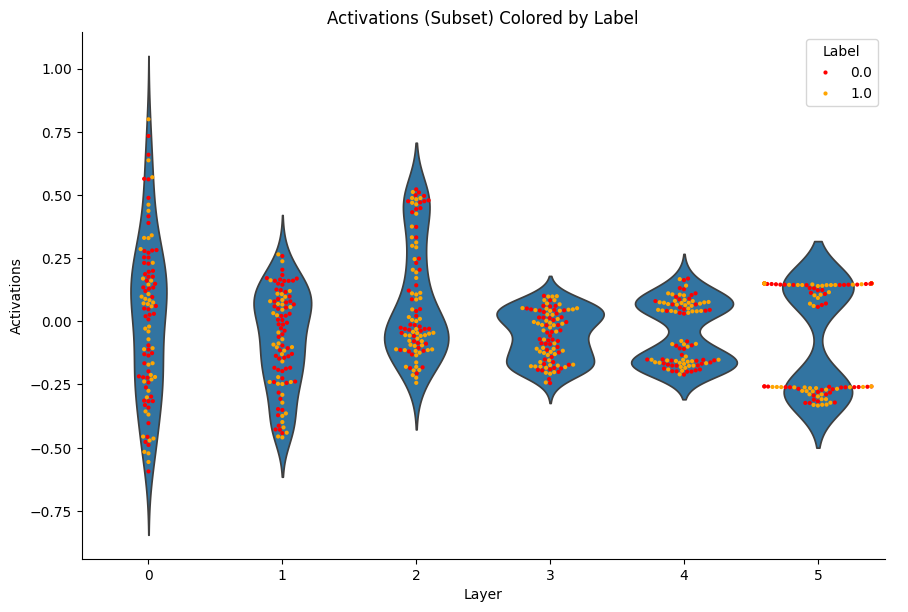

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Assuming model.act_fun and model.spline_preacts are defined
data = []
sample_size = 100  # Define the number of samples you want from each layer

# Collect activations and labels
for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun, model.spline_preacts)):
    acts_np = torch.flatten(acts).cpu().numpy()
    
    # Sample a subset of activations if there are more than sample_size
    if len(acts_np) > sample_size:
        sampled_acts = np.random.choice(acts_np, sample_size, replace=False)
    else:
        sampled_acts = acts_np  # Use all if less than sample_size
    
    # Get corresponding labels for the sampled activations
    labels = dataset['test_label'].cpu().numpy().flatten()
    
    # Sample corresponding labels
    if len(labels) > sample_size:
        sampled_labels = np.random.choice(labels, sample_size, replace=False)
    else:
        sampled_labels = labels  # Use all if less than sample_size
    
    # Append layer index, sampled activations, and labels to the data list
    data.extend([(layer_index, act, label) for act, label in zip(sampled_acts, sampled_labels)])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Layer', 'Activation', 'Label'])

# Define a color mapping
color_mapping = {0: 'red', 1: 'orange'}  # Assuming labels are 0 and 1

# Create a new column for colors based on the mapping
df['Color'] = df['Label'].map(color_mapping)

# Create a violin plot
g = sns.catplot(data=df, x="Layer", y="Activation", kind="violin", inner=None, height=6, aspect=1.5)

# Overlay a swarm plot with custom colors
sns.swarmplot(data=df, x="Layer", y="Activation", hue="Label", palette=color_mapping, size=3, ax=g.ax)

# Adding labels and title
plt.title('Activations (Subset) Colored by Label')
plt.xlabel('Layer')
plt.ylabel('Activations')

# Show plot
plt.show()

In [20]:
# model(dataset['train_input'])
# reinit_width(model)
# print("Rescaling")
# model(dataset['train_input'])
# print_ranges(model)
# model.plot()

In [21]:
# coef = model.act_fun[0].coef
# coef.mean(), coef.std()

In [22]:
# for i in range(len(width)-1):
#     print(i)
#     coef = model.act_fun[i].coef
#     print(coef.shape)


In [23]:
# stop here

In [24]:


def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

# Start MLflow run
run = mlflow.start_run()
#with mlflow.start_run() as run:
mlflow.log_param("width", width)
mlflow.log_param("steps", steps)
mlflow.log_param("grid", grid)
mlflow.log_param("k", k)
mlflow.log_param("sp_trainable", sp_trainable)
mlflow.log_param("sb_trainable", sb_trainable)
mlflow.log_param("affine_trainable", affine_trainable)
mlflow.log_param("update_grid", update_grid)

results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), 
                    update_grid=update_grid,
                    #lamb=1e-4, lamb_coef=10.0
                    );

print(results['train_acc'][-1], results['test_acc'][-1])

for i in range(len(results['train_acc'])):
    mlflow.log_metric("train_acc", results['train_acc'][i], step=i)
    mlflow.log_metric("test_acc", results['test_acc'][i], step=i)
    mlflow.log_metric("train_loss", results['train_loss'][i], step=i)
    mlflow.log_metric("test_loss", results['test_loss'][i], step=i)
    mlflow.log_metric("reg", results['reg'][i], step=i)
#mlflow.log_metric("accuracy", accuracy, step=epoch)
mlflow.pytorch.log_model(model, "model")


| train_loss: 3.25e-01 | test_loss: 4.10e-01 | reg: 3.58e+01 | : 100%|█| 100/100 [01:22<00:00,  1.22


saving model version 0.1
0.8490000367164612 0.7690000534057617


2025/03/17 21:59:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


layer_index 0
torch.Size([2, 2, 8]) torch.Size([1000, 2])
idx 0: mean: 0.20621898770332336 std: 0.3343682587146759
idx 0: -0.030215097591280937 0.4426530599594116
idx 1: mean: -0.01925314962863922 std: 0.45779821276664734
idx 1: -0.34296536445617676 0.3044590651988983
layer_index 1
torch.Size([2, 2, 8]) torch.Size([1000, 2])
idx 0: mean: -0.4045283794403076 std: 0.48512372374534607
idx 0: -0.7475626468658447 -0.061494097113609314
idx 1: mean: 0.2991907298564911 std: 0.6071053147315979
idx 1: -0.13009755313396454 0.7284790277481079
layer_index 2
torch.Size([2, 2, 8]) torch.Size([1000, 2])
idx 0: mean: -0.5050252676010132 std: 0.45845550298690796
idx 0: -0.8292022347450256 -0.18084824085235596
idx 1: mean: -0.05912208557128906 std: 0.5456699728965759
idx 1: -0.4449689984321594 0.3267248272895813
layer_index 3
torch.Size([2, 2, 8]) torch.Size([1000, 2])
idx 0: mean: 0.40160292387008667 std: 0.737432062625885
idx 0: -0.11984029412269592 0.9230461120605469
idx 1: mean: -0.05315767228603363 

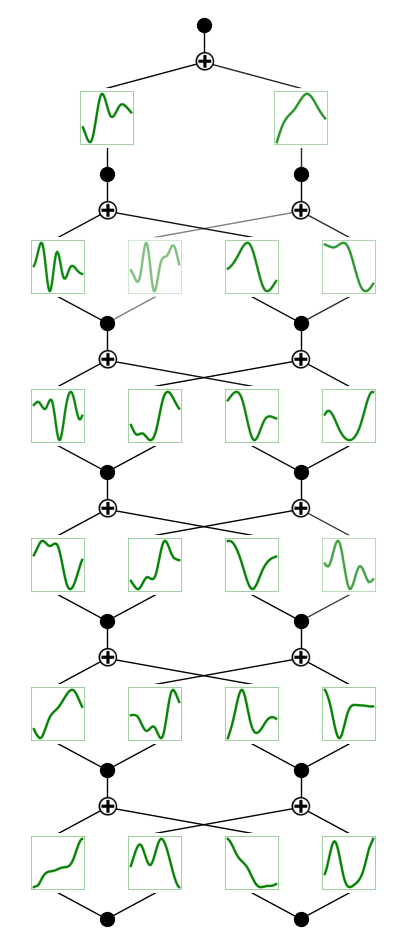

In [25]:
print_ranges(model)
model.plot()
mlflow.log_figure(model.fig, "kan-splines.png")

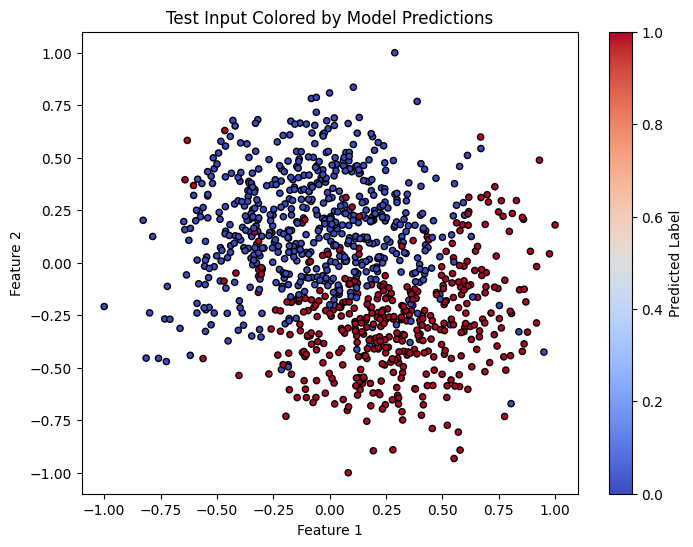

In [26]:
# Make predictions on the test input
with torch.no_grad():  # Disable gradient calculation for inference
    predictions = model(dataset['test_input'])  # Get model predictions
    predicted_labels = torch.round(predictions[:, 0]).cpu().detach().numpy()  # Round predictions to get class labels

# Create a scatter plot of the test input colored by the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(dataset['test_input'][:, 0].cpu().detach().numpy(), 
            dataset['test_input'][:, 1].cpu().detach().numpy(), 
            c=predicted_labels, cmap='coolwarm', edgecolor='k', s=20)
plt.title('Test Input Colored by Model Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Label')

mlflow.log_figure(plt.gcf(), "test_input_predictions.png")

plt.show()


In [27]:
#mlflow.end_run()

dict_keys(['train_loss', 'test_loss', 'reg', 'train_acc', 'test_acc'])


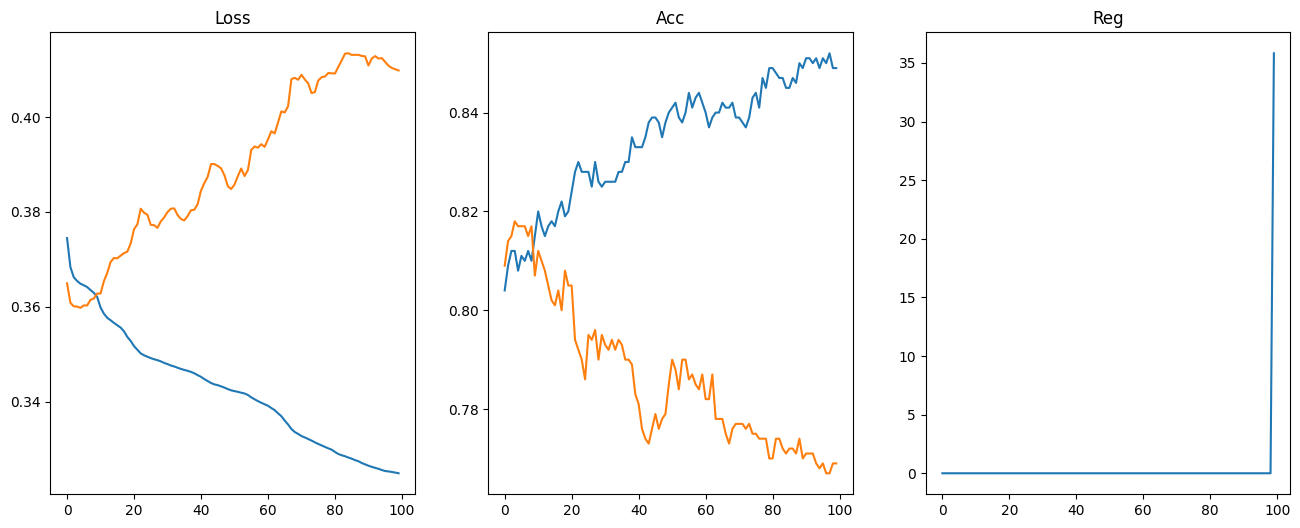

In [28]:
import matplotlib.pyplot as plt
print(results.keys())
fig, axs = plt.subplots(1,3, figsize=(16,6))
axs[0].set_title("Loss")
axs[0].plot(results['train_loss'], label="train_loss")
axs[0].plot(results['test_loss'], label="test_loss")

axs[1].set_title("Acc")
axs[1].plot(results['train_acc'], label="train_acc")
axs[1].plot(results['test_acc'], label="test_acc")

axs[2].set_title("Reg")
axs[2].plot(results['reg'])

plt.show()

Automatic symbolic regression

In [29]:


mlflow.end_run()

In [30]:
# Normal
# train acc of the formula: tensor(0.8430, device='cuda:0')
# test acc of the formula: tensor(0.8480, device='cuda:0')

# Sigmoid, CumSum
# train acc of the formula: tensor(0.7470, device='cuda:0')
# test acc of the formula: tensor(0.7440, device='cuda:0')

In [31]:
means = []
vars = []
mins = []
maxs = []
for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun,model.spline_preacts)):
    grid_num = act_fun.num
    coef = act_fun.coef

    mean_value = acts.mean()
    var_value = acts.var()
    min_value = acts.min()
    max_value = acts.max()

    means.append(mean_value.cpu().numpy())
    vars.append(var_value.cpu().numpy())
    mins.append(min_value.cpu().numpy())
    maxs.append(max_value.cpu().numpy())

    print(layer_index, grid_num, coef.shape, acts.shape)
    print(f"mean={mean_value:.2e}, var={var_value:.2e}, min={min_value:.2e}, max={max_value:.2e}")

0 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=3.36e-02, var=1.23e-01, min=-1.00e+00, max=1.00e+00
1 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=-1.45e-01, var=2.33e-01, min=-1.33e+00, max=1.39e+00
2 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=-2.46e-01, var=2.80e-01, min=-1.16e+00, max=1.34e+00
3 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=1.81e-01, var=3.04e-01, min=-1.70e+00, max=1.16e+00
4 5 torch.Size([2, 2, 8]) torch.Size([1000, 2, 2])
mean=-1.19e-02, var=1.76e-01, min=-1.53e+00, max=1.31e+00
5 5 torch.Size([2, 1, 8]) torch.Size([1000, 1, 2])
mean=2.28e-03, var=1.66e-01, min=-7.74e-01, max=1.50e+00


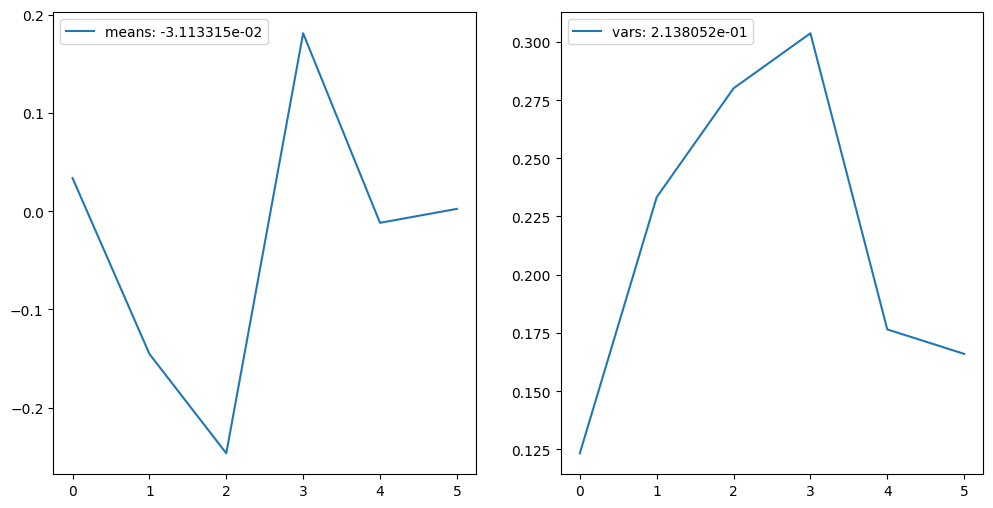

In [32]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(means, label=f"means: {np.mean(means):2e}")
axs[0].legend()
axs[1].plot(vars, label=f"vars: {np.mean(vars):2e}")
axs[1].legend()
plt.show()

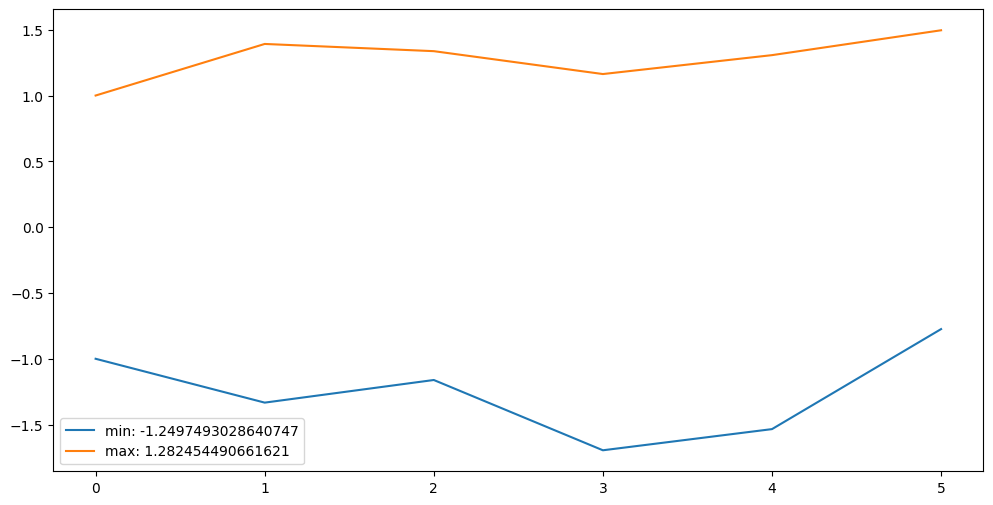

In [33]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
axs.plot(mins, label=f"min: {np.mean(mins)}")
axs.plot(maxs, label=f"max: {np.mean(maxs)}")
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

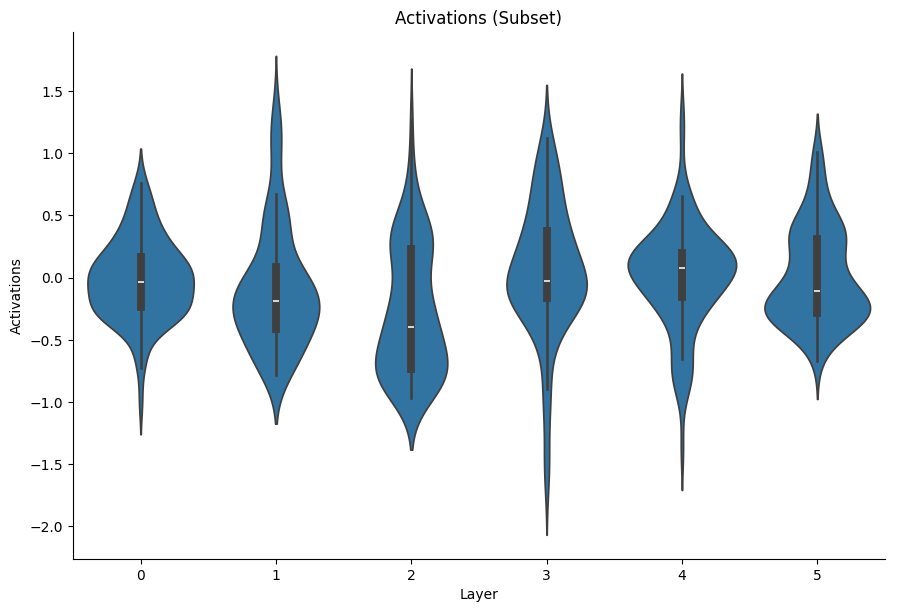

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Assuming model.act_fun and model.spline_preacts are defined
data = []
sample_size = 100  # Define the number of samples you want from each layer

for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun, model.spline_preacts)):
    acts_np = torch.flatten(acts).cpu().numpy()
    
    # Sample a subset of activations if there are more than sample_size
    if len(acts_np) > sample_size:
        sampled_acts = np.random.choice(acts_np, sample_size, replace=False)
    else:
        sampled_acts = acts_np  # Use all if less than sample_size
    
    # Append layer index and sampled activations to the data list
    data.extend([(layer_index, act) for act in sampled_acts])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Layer', 'Activation'])

plt.figure(figsize=(12, 6))

# Create a violin plot
sns.catplot(data=df, x="Layer", y="Activation", kind="violin", height=6, aspect=1.5)

# Adding labels and title
plt.title('Activations (Subset)')
plt.xlabel('Layer')
plt.ylabel('Activations')

# Show plot
plt.show()

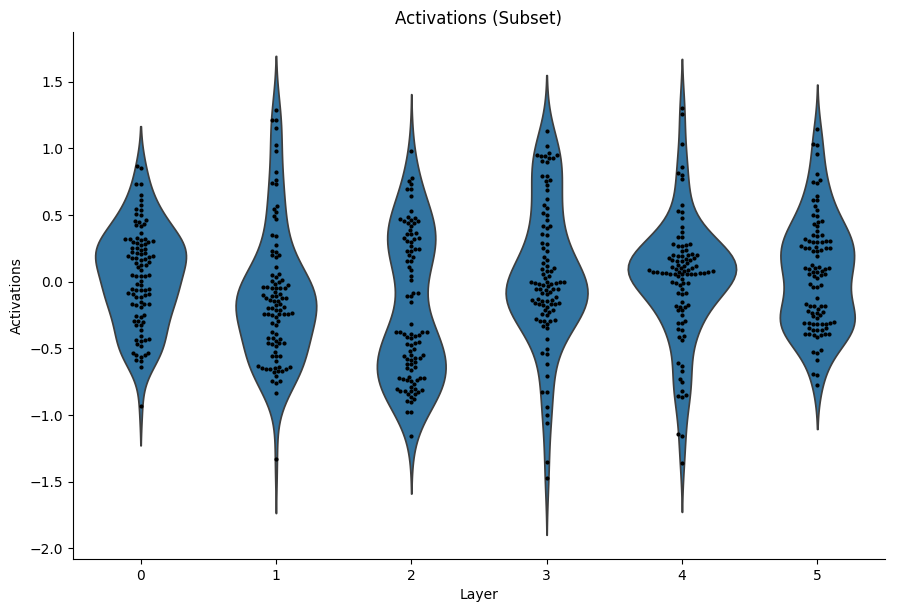

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Assuming model.act_fun and model.spline_preacts are defined
data = []
sample_size = 100  # Define the number of samples you want from each layer

for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun, model.spline_preacts)):
    acts_np = torch.flatten(acts).cpu().numpy()
    
    # Sample a subset of activations if there are more than sample_size
    if len(acts_np) > sample_size:
        sampled_acts = np.random.choice(acts_np, sample_size, replace=False)
    else:
        sampled_acts = acts_np  # Use all if less than sample_size
    
    # Append layer index and sampled activations to the data list
    data.extend([(layer_index, act) for act in sampled_acts])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Layer', 'Activation'])

# Create a violin plot
g = sns.catplot(data=df, x="Layer", y="Activation", kind="violin", inner=None, height=6, aspect=1.5)

# Overlay a swarm plot
sns.swarmplot(data=df, x="Layer", y="Activation", color="k", size=3, ax=g.ax)

# Adding labels and title
plt.title('Activations (Subset)')
plt.xlabel('Layer')
plt.ylabel('Activations')

# Show plot
plt.show()

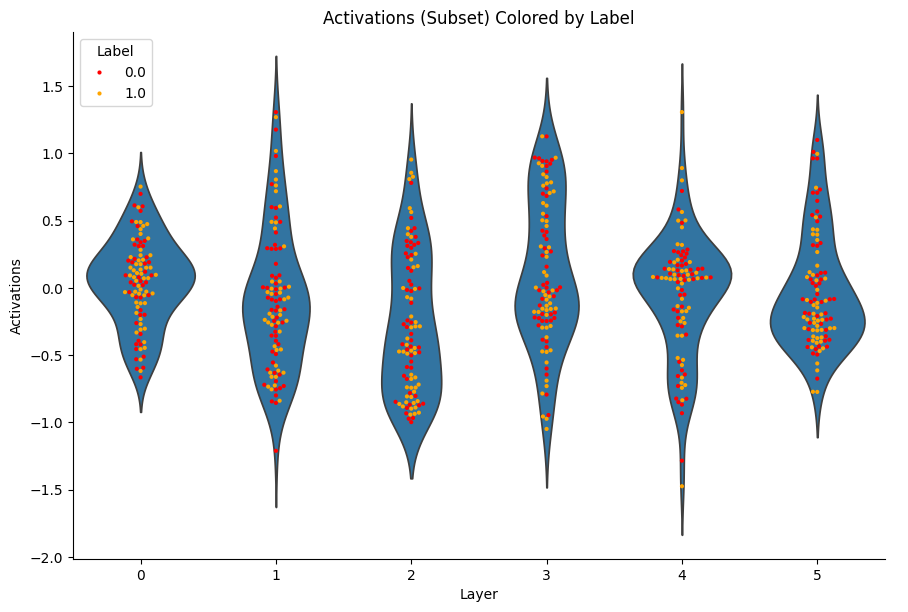

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

# Assuming model.act_fun and model.spline_preacts are defined
data = []
sample_size = 100  # Define the number of samples you want from each layer

# Collect activations and labels
for layer_index, (act_fun, acts) in enumerate(zip(model.act_fun, model.spline_preacts)):
    acts_np = torch.flatten(acts).cpu().numpy()
    
    # Sample a subset of activations if there are more than sample_size
    if len(acts_np) > sample_size:
        sampled_acts = np.random.choice(acts_np, sample_size, replace=False)
    else:
        sampled_acts = acts_np  # Use all if less than sample_size
    
    # Get corresponding labels for the sampled activations
    labels = dataset['test_label'].cpu().numpy().flatten()
    
    # Sample corresponding labels
    if len(labels) > sample_size:
        sampled_labels = np.random.choice(labels, sample_size, replace=False)
    else:
        sampled_labels = labels  # Use all if less than sample_size
    
    # Append layer index, sampled activations, and labels to the data list
    data.extend([(layer_index, act, label) for act, label in zip(sampled_acts, sampled_labels)])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Layer', 'Activation', 'Label'])

# Define a color mapping
color_mapping = {0: 'red', 1: 'orange'}  # Assuming labels are 0 and 1

# Create a new column for colors based on the mapping
df['Color'] = df['Label'].map(color_mapping)

# Create a violin plot
g = sns.catplot(data=df, x="Layer", y="Activation", kind="violin", inner=None, height=6, aspect=1.5)

# Overlay a swarm plot with custom colors
sns.swarmplot(data=df, x="Layer", y="Activation", hue="Label", palette=color_mapping, size=3, ax=g.ax)

# Adding labels and title
plt.title('Activations (Subset) Colored by Label')
plt.xlabel('Layer')
plt.ylabel('Activations')

# Show plot
plt.show()

In [37]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

In [ ]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [ ]:
#width=[2,2]
width = [2,*base_width,2]
model = KAN(width=width, grid=grid, k=k, seed=2024, device=device,
            sp_trainable=False, sb_trainable=False, affine_trainable=False,
            base_fun="zero",
            mode=None
            )

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss(), update_grid=False);

In [ ]:
model.plot()

In [ ]:
# Make predictions on the test input
with torch.no_grad():  # Disable gradient calculation for inference
    predictions = model(dataset['test_input'])  # Get model predictions
    predicted_labels = torch.argmax(predictions, dim=1).cpu().detach().numpy()  # Get class labels from one-hot encoded predictions

# Create a scatter plot of the test input colored by the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(dataset['test_input'][:, 0].cpu().detach().numpy(), 
            dataset['test_input'][:, 1].cpu().detach().numpy(), 
            c=predicted_labels, cmap='coolwarm', edgecolor='k', s=20)
plt.title('Test Input Colored by Model Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Label')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
print(results.keys())
fig, axs = plt.subplots(1,3, figsize=(16,6))
axs[0].set_title("Loss")
axs[0].plot(results['train_loss'], label="train_loss")
axs[0].plot(results['test_loss'], label="test_loss")

axs[1].set_title("Acc")
axs[1].plot(results['train_acc'], label="train_acc")
axs[1].plot(results['test_acc'], label="test_acc")

axs[2].set_title("Reg")
axs[2].plot(results['reg'])

plt.show()

Automatic symbolic regression

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

In [ ]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

In [ ]:
ex_round(formula2, 4)

How accurate is this formula?

In [ ]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

In [ ]:
# Normal
# train acc of the formula: tensor(0.8170, device='cuda:0')
# test acc of the formula: tensor(0.8240, device='cuda:0')

# Sigmoid, CumSum
# train acc of the formula: tensor(0.8530, device='cuda:0')
# test acc of the formula: tensor(0.8450, device='cuda:0')

In [ ]:
model.plot()

In [ ]:
# Make predictions on the test input
with torch.no_grad():  # Disable gradient calculation for inference
    predictions = model(dataset['test_input'])  # Get model predictions
    predicted_labels = torch.argmax(predictions, dim=1).cpu().detach().numpy()  # Get class labels from one-hot encoded predictions

# Create a scatter plot of the test input colored by the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(dataset['test_input'][:, 0].cpu().detach().numpy(), 
            dataset['test_input'][:, 1].cpu().detach().numpy(), 
            c=predicted_labels, cmap='coolwarm', edgecolor='k', s=20)
plt.title('Test Input Colored by Model Predictions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Predicted Label')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
print(results.keys())
fig, axs = plt.subplots(1,3, figsize=(16,6))
axs[0].set_title("Loss")
axs[0].plot(results['train_loss'], label="train_loss")
axs[0].plot(results['test_loss'], label="test_loss")

axs[1].set_title("Acc")
axs[1].plot(results['train_acc'], label="train_acc")
axs[1].plot(results['test_acc'], label="test_acc")

axs[2].set_title("Reg")
axs[2].plot(results['reg'])

plt.show()